### Compute equilibrium for the no-aggregate uncertainty KS model

Proof of concept for computing the equilibrium for the model. Then, using the equilibrium aggregate capital, compute the stationary distribution (and decision rules) and plot them. 

This code does not make use of CompEcon, or rely on linear basis matrices. 

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa
import matplotlib.pyplot as plt
from dolo.algos.dtmscc.time_iteration import time_iteration
from dolo import yaml_import
from dolo import pcat
import dolo.algos.dtmscc.distributions as dst


In [4]:
filename = 'incomplete_markets_dtmscc.yaml'
model = yaml_import(filename)

Ne = 2
Nkf = 1000
kgridf = dst.fine_grid(model, Nkf)

In [3]:
mdr = time_iteration(model2, with_complementarities=True, verbose=True, output_type='dr') 

Solving WITH complementarities.
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
|   1 |  2.339e-01 |      nan |    0.579 |   8 |
|   2 |  1.308e-02 |    0.056 |    0.011 |   4 |
|   3 |  1.024e-02 |    0.783 |    0.011 |   4 |
|   4 |  8.179e-03 |    0.799 |    0.011 |   4 |
|   5 |  6.645e-03 |    0.812 |    0.008 |   3 |
|   6 |  5.473e-03 |    0.824 |    0.008 |   3 |
|   7 |  4.560e-03 |    0.833 |    0.008 |   3 |
|   8 |  3.836e-03 |    0.841 |    0.008 |   3 |
|   9 |  3.254e-03 |    0.848 |    0.011 |   4 |
|  10 |  2.781e-03 |    0.855 |    0.010 |   4 |
|  11 |  2.459e-03 |    0.884 |    0.010 |   4 |
|  12 |  2.629e-03 |    1.069 |    0.011 |   4 |
|  13 |  2.612e-03 |    0.994 |    0.012 |   4 |
|  14 |  2.500e-03 |    0.957 |    0.008 |   3 |
|  15 |  2.360e-03 |    0.944 |    0.008 |   3 |
|  16 |  2.231e-03 |    0.945 |    0.008 |   3 |
|  17 |  2.127e-03 |    0.954 |    0.

### Compute the equilibrium interest rate 

In [3]:
K = dst.solve_eqm(model, Kinit=38, tolKeq=1e-5, verbose=True)

Iteration = 	0: K=	38.0000  Kagg=	98.7978

Iteration = 	1: K=	38.0608  Kagg=	98.5146

Iteration = 	2: K=	38.4232  Kagg=	57.4972

Iteration = 	3: K=	38.6324  Kagg=	39.4280

Iteration = 	4: K=	38.6450  Kagg=	39.0059

Iteration = 	5: K=	38.6525  Kagg=	38.7659

Iteration = 	6: K=	38.6555  Kagg=	38.6748

Iteration = 	7: K=	38.6560  Kagg=	38.6564



### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [4]:
# Set model calibration to the equilibrium aggregate capital stock.
model.set_calibration(kagg=K)

# drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [5]:
L, QT = dst.stat_dist(model, mdr, Nkf=Nkf, verbose=False)

### Plot the equilibrium stationary distribution and decision rules

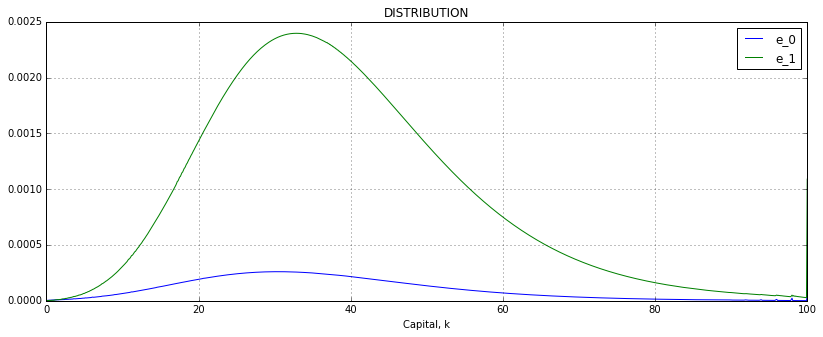

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

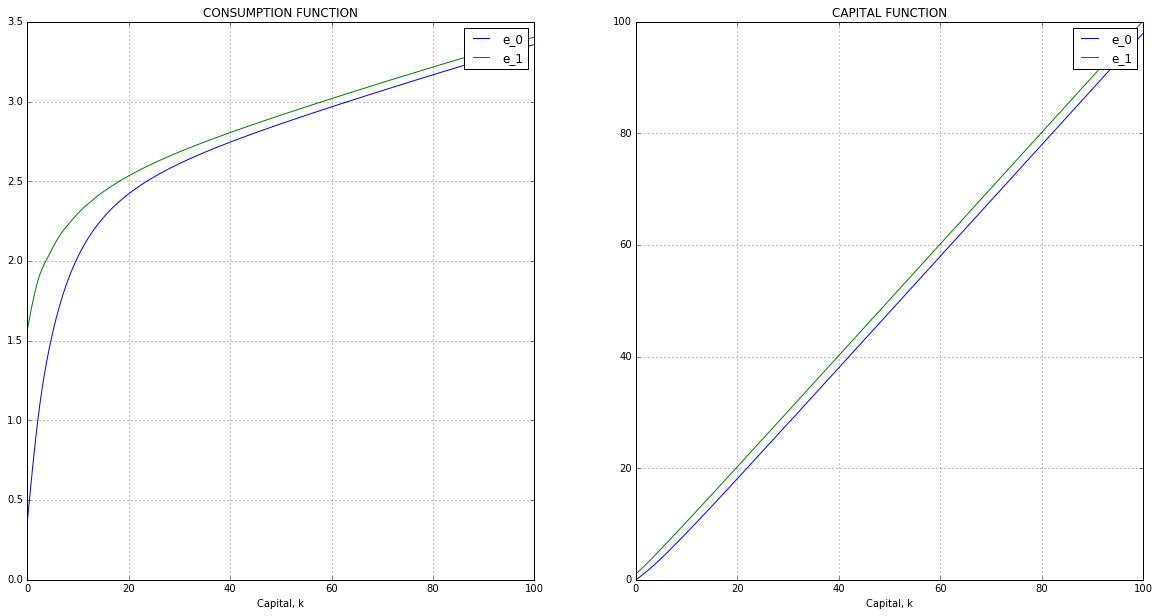

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

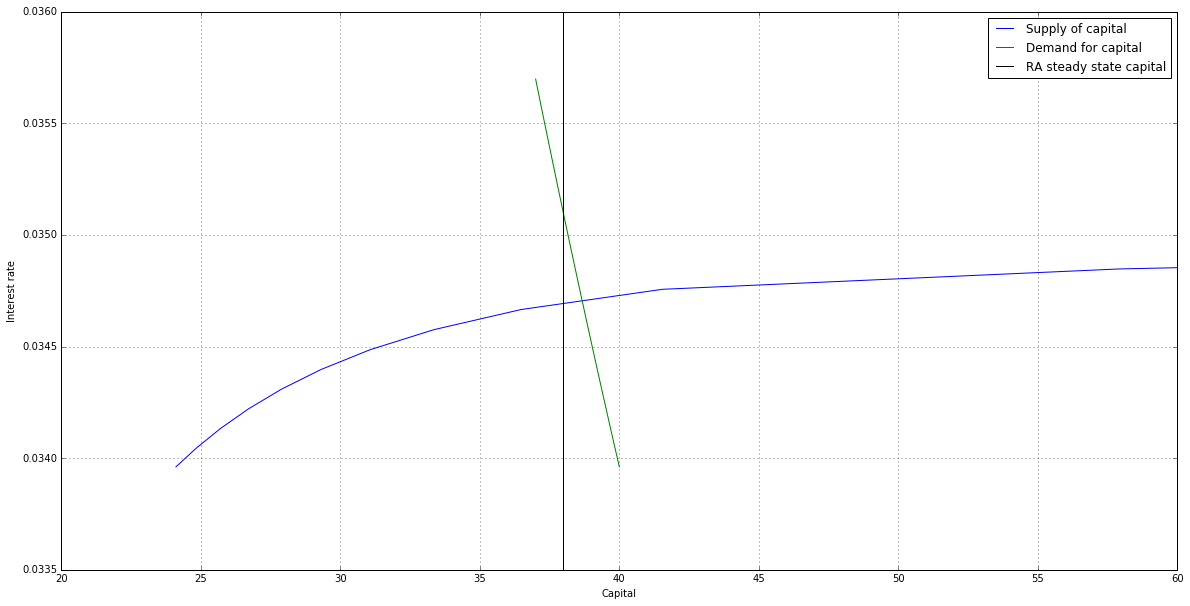

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 